In [1]:
# Importar librerias
import pandas as pd
import numpy as np

# Lectura de datasets
df_features = pd.read_csv("part-00000-cf647b09-77a9-4d0a-a4ef-6c582791e2ac-c000.csv")
df_med = pd.read_csv("datos_medellin.csv", sep=None, engine="python")

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_21136\1992331824.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_features = pd.read_csv("part-00000-cf647b09-77a9-4d0a-a4ef-6c582791e2ac-c000.csv")


In [2]:
# Se renombra la columna solo_fecha
df_features = df_features.rename(columns={"solo_fecha": "fecha"})

# Filtra solo algunos tipos de casos
df_llamadas = df_features[
    df_features["grupo_caso"].isin([
        "Riña", "Hurto calificado", "Perturbacion",
        "Hurto entidad comercial", "Hurto simple o raponazo",
        "Vehiculo hurtado", "Violacion de domicilio"
    ])
].copy()

# Se hace una copia del dataset
df_llamadas_pre_agrupado = df_llamadas.copy()

# Combina las columnas "fecha" y "hora" en una sola   
# ESTO LO ESTAMOS HACIENDO 2 VECES !!! EN EL EDA SE SEPARA Y AQUI SE VUELVE A COMBINAR
df_llamadas_pre_agrupado["fecha"] = pd.to_datetime(
    df_llamadas_pre_agrupado["fecha"] + " " + df_llamadas_pre_agrupado["hora"],
    errors="coerce"
)

# Se extrae la hora y mes en nuevas columnas
df_llamadas_pre_agrupado["hora"] = df_llamadas_pre_agrupado["fecha"].dt.hour
df_llamadas_pre_agrupado["mes"] = df_llamadas_pre_agrupado["fecha"].dt.month

# Convierte fechas a un contador de meses desde el inicio
df_llamadas_pre_agrupado["mes_global"] = (
    (df_llamadas_pre_agrupado["fecha"].dt.year - df_llamadas_pre_agrupado["fecha"].dt.year.min()) * 12
    + df_llamadas_pre_agrupado["fecha"].dt.month
)

# Extrae el día: 1=Lunes, 2=Martes... 7=Domingo
df_llamadas_pre_agrupado["dia_semana"] = df_llamadas_pre_agrupado["fecha"].dt.weekday + 1

# Clasificación de turnos
df_llamadas_pre_agrupado["turno"] = df_llamadas_pre_agrupado["hora"].apply(
    lambda h: "PT" if h >= 23 or h < 7 else ("ST" if h < 14 else "TT")
)

# Se queda solo con datos hasta Oct 31, 2025
df_llamadas_pre_agrupado = df_llamadas_pre_agrupado[
    df_llamadas_pre_agrupado["fecha"] <= "2025-10-31"
].copy()

In [3]:
# Agrupar y contar
df_modelo = (
    df_llamadas_pre_agrupado
    .groupby(["dia_semana", "turno", "mes_global", "codigo_barrio", "grupo_caso"])
    .size()
    .reset_index(name="cantidad")
)


# Crear todas las combinaciones posibles (complete())
dias = df_modelo["dia_semana"].unique()
turnos = df_modelo["turno"].unique()
meses = df_modelo["mes_global"].unique()
barrios = df_modelo["codigo_barrio"].unique()
grupos = df_modelo["grupo_caso"].unique()

idx = pd.MultiIndex.from_product(
    [dias, turnos, meses, barrios, grupos],
    names=["dia_semana", "turno", "mes_global", "codigo_barrio", "grupo_caso"]
)

# Convierte esas 5 columnas en el índice del dataframe y llena los valores nulos con 0
df_modelo = (
    df_modelo.set_index(["dia_semana", "turno", "mes_global", "codigo_barrio", "grupo_caso"])
             .reindex(idx, fill_value=0)
             .reset_index()
)


# left_join por mes_global (anio y mes)
df_aux = (
    df_llamadas_pre_agrupado[["mes_global", "anio", "mes"]]
    .drop_duplicates()
)

df_modelo = df_modelo.merge(df_aux, on="mes_global", how="left")

In [4]:
# Copiar el dataset
df_llamadas_post_agrupado = df_modelo.copy()

# Convierte mes global en entero
df_llamadas_post_agrupado["mes_global"] = df_llamadas_post_agrupado["mes_global"].astype(int)

# Ordena las filas
df_llamadas_post_agrupado = df_llamadas_post_agrupado.sort_values(
    ["dia_semana", "turno", "codigo_barrio", "grupo_caso", "mes_global"]
).reset_index(drop=True)


# crea variables de rezago temporal (lag features) para predicción
def fn_rolling(group):
    group = group.sort_values("mes_global").copy()
    group["cantidad_mes_anterior"] = group["cantidad"].shift(1)
    group["promedio_3m"] = group["cantidad_mes_anterior"].rolling(3, min_periods=3).mean()
    return group

# Aplica la función fn_rolling a cada grupo independiente
df_llamadas_post_agrupado = df_llamadas_post_agrupado.groupby(
    ["dia_semana","turno","codigo_barrio","grupo_caso"],
    group_keys=False
).apply(fn_rolling)


# calcula la proporción que representa cada turno dentro del total del día
df_llamadas_post_agrupado["propor_turno_mes_ant"] = (
    df_llamadas_post_agrupado["cantidad_mes_anterior"] /
    df_llamadas_post_agrupado.groupby(
        ["dia_semana", "codigo_barrio", "grupo_caso", "mes_global"]
    )["cantidad_mes_anterior"].transform("sum")
).fillna(0)


# calcula la proporción que representa cada día dentro del total del turno
df_llamadas_post_agrupado["propor_dia_mes_ant"] = (
    df_llamadas_post_agrupado["cantidad_mes_anterior"] /
    df_llamadas_post_agrupado.groupby(
        ["turno", "codigo_barrio", "grupo_caso", "mes_global"]
    )["cantidad_mes_anterior"].transform("sum")
).fillna(0)


# Ordena cronológicamente los registros
df_features = df_llamadas_post_agrupado.sort_values(
    ["dia_semana","turno","codigo_barrio","grupo_caso","mes_global"]
).copy()

# Agrupa por día + turno + barrio + delito (cada serie temporal)
g2 = df_features.groupby(
    ["dia_semana","turno","codigo_barrio","grupo_caso"],
    group_keys=False
)

# Crear variables auxiliares con .shift()
df_features["cantidad_2_meses"] = g2["cantidad"].shift(2)
df_features["cantidad_3_meses"] = g2["cantidad"].shift(3)

# Calcular variación porcentual
df_features["variacion_mes_anterior"] = (
    (df_features["cantidad_2_meses"] - df_features["cantidad_3_meses"]) /
    df_features["cantidad_3_meses"]
).replace([np.inf,-np.inf,np.nan],0)

# Eliminar columnas auxiliares
df_features = df_features.drop(columns=["cantidad_2_meses", "cantidad_3_meses"], errors='ignore')

# calcula el total de llamadas del mes anterior para ese día completo (sumando todos los turnos)
df_features["total_dia_mes_ant"] = df_features.groupby(
    ["dia_semana","codigo_barrio","grupo_caso","mes_global"]
)["cantidad_mes_anterior"].transform("sum")


# total_delito_barrio
df_features["total_delito_barrio"] = df_features.groupby(
    ["codigo_barrio","grupo_caso","mes_global"]
)["cantidad_mes_anterior"].transform("sum")


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_21136\1683352368.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(fn_rolling)


In [5]:
#identificar NAN
print(f"Suma de valores nulos por columna: /n {df_features.isnull().sum()}")
print(f"Total de valores nulos en todo el DataFrame: {df_features.isnull().sum().sum()}") 
print(f"Porcentaje de NaN por columna /n {df_features.isnull().sum() / len(df_features) * 100}") # Porcentaje de NaN por columna
df_features.head()

Suma de valores nulos por columna: /n dia_semana                     0
turno                          0
mes_global                     0
codigo_barrio                  0
grupo_caso                     0
cantidad                       0
anio                           0
mes                            0
cantidad_mes_anterior      63063
promedio_3m               189189
propor_turno_mes_ant           0
propor_dia_mes_ant             0
variacion_mes_anterior         0
total_dia_mes_ant              0
total_delito_barrio            0
dtype: int64
Total de valores nulos en todo el DataFrame: 252252
Porcentaje de NaN por columna /n dia_semana                0.000000
turno                     0.000000
mes_global                0.000000
codigo_barrio             0.000000
grupo_caso                0.000000
cantidad                  0.000000
anio                      0.000000
mes                       0.000000
cantidad_mes_anterior     2.941176
promedio_3m               8.823529
propor_turno_mes_an

,dia_semana,turno,mes_global,codigo_barrio,grupo_caso,cantidad,anio,mes,cantidad_mes_anterior,promedio_3m,propor_turno_mes_ant,propor_dia_mes_ant,variacion_mes_anterior,total_dia_mes_ant,total_delito_barrio
0,1,PT,1,101,Hurto calificado,0,2023,1,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1,1,PT,2,101,Hurto calificado,0,2023,2,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2,1,PT,3,101,Hurto calificado,0,2023,3,0.0,NaN,0.0,0.0,0.0,0.0,2.0
3,1,PT,4,101,Hurto calificado,0,2023,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,PT,5,101,Hurto calificado,0,2023,5,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [6]:
# Imputa valores nulos con ceros
df_features = df_features.fillna(0)

In [7]:
#  MERGE + LIMPIEZA + COLUMNA ÚNICA DE POBLACIÓN

# Conversión tipo de datos
df_features["anio"] = df_features["anio"].astype(int)

df_features["codigo_barrio"] = df_features["codigo_barrio"].astype(str)
df_med["codigo_barrio"] = df_med["codigo_barrio"].astype(str)

df_features["codigo_barrio"] = df_features["codigo_barrio"].str.lstrip("0")

# Se realiza el merge del dataset df_features con df_med
df_features = df_features.merge(
    df_med[
        [
            "codigo_barrio",
            "poblacion_2023",
            "poblacion_2024",
            "poblacion_2025",
            "estrato_promedio",
            "area_m2",
            "Personas en ejercicio de mendicidad",
            "Concentración de habitantes de calle",
            "Concentración de población migrante",
            "Lavaderos informales",
            "Falta de alumbrado público",
            "Mal estacionamiento de vehículos",
            "Inquilinatos",
            "Concentración habitantes de calle según EP"
        ]
    ],
    on="codigo_barrio",
    how="left"
)

#  consolida múltiples columnas de población en una sola
df_features["poblacion"] = df_features.apply(
    lambda row: row[f"poblacion_{row['anio']}"],
    axis=1
)


df_features = df_features.drop(
    columns=["poblacion_2023","poblacion_2024","poblacion_2025"] ##Por que se elimina la población 2025 ?????
)


In [8]:
#identificar NAN
print(f"Suma de valores nulos por columna: /n {df_features.isnull().sum()}")
print(f"Total de valores nulos en todo el DataFrame: {df_features.isnull().sum().sum()}") 
print(f"Porcentaje de NaN por columna /n {df_features.isnull().sum() / len(df_features) * 100}") # Porcentaje de NaN por columna
df_features.head()

Suma de valores nulos por columna: /n dia_semana                                    0
turno                                         0
mes_global                                    0
codigo_barrio                                 0
grupo_caso                                    0
cantidad                                      0
anio                                          0
mes                                           0
cantidad_mes_anterior                         0
promedio_3m                                   0
propor_turno_mes_ant                          0
propor_dia_mes_ant                            0
variacion_mes_anterior                        0
total_dia_mes_ant                             0
total_delito_barrio                           0
estrato_promedio                              0
area_m2                                       0
Personas en ejercicio de mendicidad           0
Concentración de habitantes de calle          0
Concentración de población migrante           0
La

,dia_semana,turno,mes_global,codigo_barrio,grupo_caso,cantidad,anio,mes,cantidad_mes_anterior,promedio_3m,...,area_m2,Personas en ejercicio de mendicidad,Concentración de habitantes de calle,Concentración de población migrante,Lavaderos informales,Falta de alumbrado público,Mal estacionamiento de vehículos,Inquilinatos,Concentración habitantes de calle según EP,poblacion
0,1,PT,1,101,Hurto calificado,0,2023,1,0.0,0.0,...,561247.6598,F,V,V,F,F,V,V,F,25316
1,1,PT,2,101,Hurto calificado,0,2023,2,0.0,0.0,...,561247.6598,F,V,V,F,F,V,V,F,25316
2,1,PT,3,101,Hurto calificado,0,2023,3,0.0,0.0,...,561247.6598,F,V,V,F,F,V,V,F,25316
3,1,PT,4,101,Hurto calificado,0,2023,4,0.0,0.0,...,561247.6598,F,V,V,F,F,V,V,F,25316
4,1,PT,5,101,Hurto calificado,0,2023,5,0.0,0.0,...,561247.6598,F,V,V,F,F,V,V,F,25316


In [9]:
cols = [
    'Personas en ejercicio de mendicidad',
    'Concentración de habitantes de calle',
    'Concentración de población migrante',
    'Lavaderos informales',
    'Falta de alumbrado público',
    'Mal estacionamiento de vehículos',
    'Inquilinatos',
    'Concentración habitantes de calle según EP'
]

# convierte variables categóricas a numéricas
df_features[cols] = df_features[cols].replace({'F': 0, 'V': 1}).astype('Int64')

df_features["turno"] = df_features["turno"].replace({
    "PT": 1,
    "ST": 2,
    "TT": 3
}).astype(int)



C:\Users\USUARIO\AppData\Local\Temp\ipykernel_21136\970089971.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_features[cols] = df_features[cols].replace({'F': 0, 'V': 1}).astype('Int64')
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_21136\970089971.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_features["turno"] = df_features["turno"].replace({


In [10]:
print(df_features.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154138 entries, 0 to 2154137
Data columns (total 26 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   dia_semana                                  int32  
 1   turno                                       int64  
 2   mes_global                                  int64  
 3   codigo_barrio                               object 
 4   grupo_caso                                  object 
 5   cantidad                                    int64  
 6   anio                                        int64  
 7   mes                                         int32  
 8   cantidad_mes_anterior                       float64
 9   promedio_3m                                 float64
 10  propor_turno_mes_ant                        float64
 11  propor_dia_mes_ant                          float64
 12  variacion_mes_anterior                      float64
 13  total_dia_mes_ant          

In [11]:
from sklearn.preprocessing import StandardScaler

# One‑hot encode de las categorías
df_corr = df_features.drop(columns=["codigo_barrio", "grupo_caso", "cantidad"])
df_features = pd.get_dummies(df_features, columns=["codigo_barrio", "grupo_caso"], drop_first=False)

# Estandariza (normaliza) las variables numéricas
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)
df_corr_scaled = scaler.fit_transform(df_corr)


In [12]:
# convierte los arrays numpy de vuelta a DataFrames
df_corr_scaled = pd.DataFrame(df_corr_scaled, columns=df_corr.columns)
df_scaled = pd.DataFrame(df_scaled, columns=df_features.columns)
df_scaled

,dia_semana,turno,mes_global,cantidad,anio,mes,cantidad_mes_anterior,promedio_3m,propor_turno_mes_ant,propor_dia_mes_ant,...,codigo_barrio_AE7,codigo_barrio_AUC1,codigo_barrio_AUC2,grupo_caso_Hurto calificado,grupo_caso_Hurto entidad comercial,grupo_caso_Hurto simple o raponazo,grupo_caso_Perturbacion,grupo_caso_Riña,grupo_caso_Vehiculo hurtado,grupo_caso_Violacion de domicilio
0,-1.5,-1.224745,-1.681836,-0.240334,-1.173177,-1.566372,-0.23686,-0.263434,-0.320449,-0.274306,...,-0.048224,-0.048224,-0.048224,2.449490,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248
1,-1.5,-1.224745,-1.579906,-0.240334,-1.173177,-1.265487,-0.23686,-0.263434,-0.320449,-0.274306,...,-0.048224,-0.048224,-0.048224,2.449490,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248
2,-1.5,-1.224745,-1.477977,-0.240334,-1.173177,-0.964602,-0.23686,-0.263434,-0.320449,-0.274306,...,-0.048224,-0.048224,-0.048224,2.449490,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248
3,-1.5,-1.224745,-1.376047,-0.240334,-1.173177,-0.663717,-0.23686,-0.263434,-0.320449,-0.274306,...,-0.048224,-0.048224,-0.048224,2.449490,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248
4,-1.5,-1.224745,-1.274118,-0.240334,-1.173177,-0.362832,-0.23686,-0.263434,-0.320449,-0.274306,...,-0.048224,-0.048224,-0.048224,2.449490,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154133,1.5,1.224745,1.274118,-0.240334,1.319824,-0.061947,-0.23686,-0.263434,-0.320449,-0.274306,...,-0.048224,-0.048224,20.736441,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,2.449490
2154134,1.5,1.224745,1.376047,-0.240334,1.319824,0.238938,-0.23686,-0.263434,-0.320449,-0.274306,...,-0.048224,-0.048224,20.736441,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,2.449490
2154135,1.5,1.224745,1.477977,-0.240334,1.319824,0.539823,-0.23686,-0.263434,-0.320449,-0.274306,...,-0.048224,-0.048224,20.736441,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,2.449490
2154136,1.5,1.224745,1.579906,-0.240334,1.319824,0.840708,-0.23686,-0.263434,-0.320449,-0.274306,...,-0.048224,-0.048224,20.736441,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,-0.408248,2.449490


In [13]:
# calcula la matriz de correlación entre todas las variables
corr_matrix = df_corr_scaled.corr()

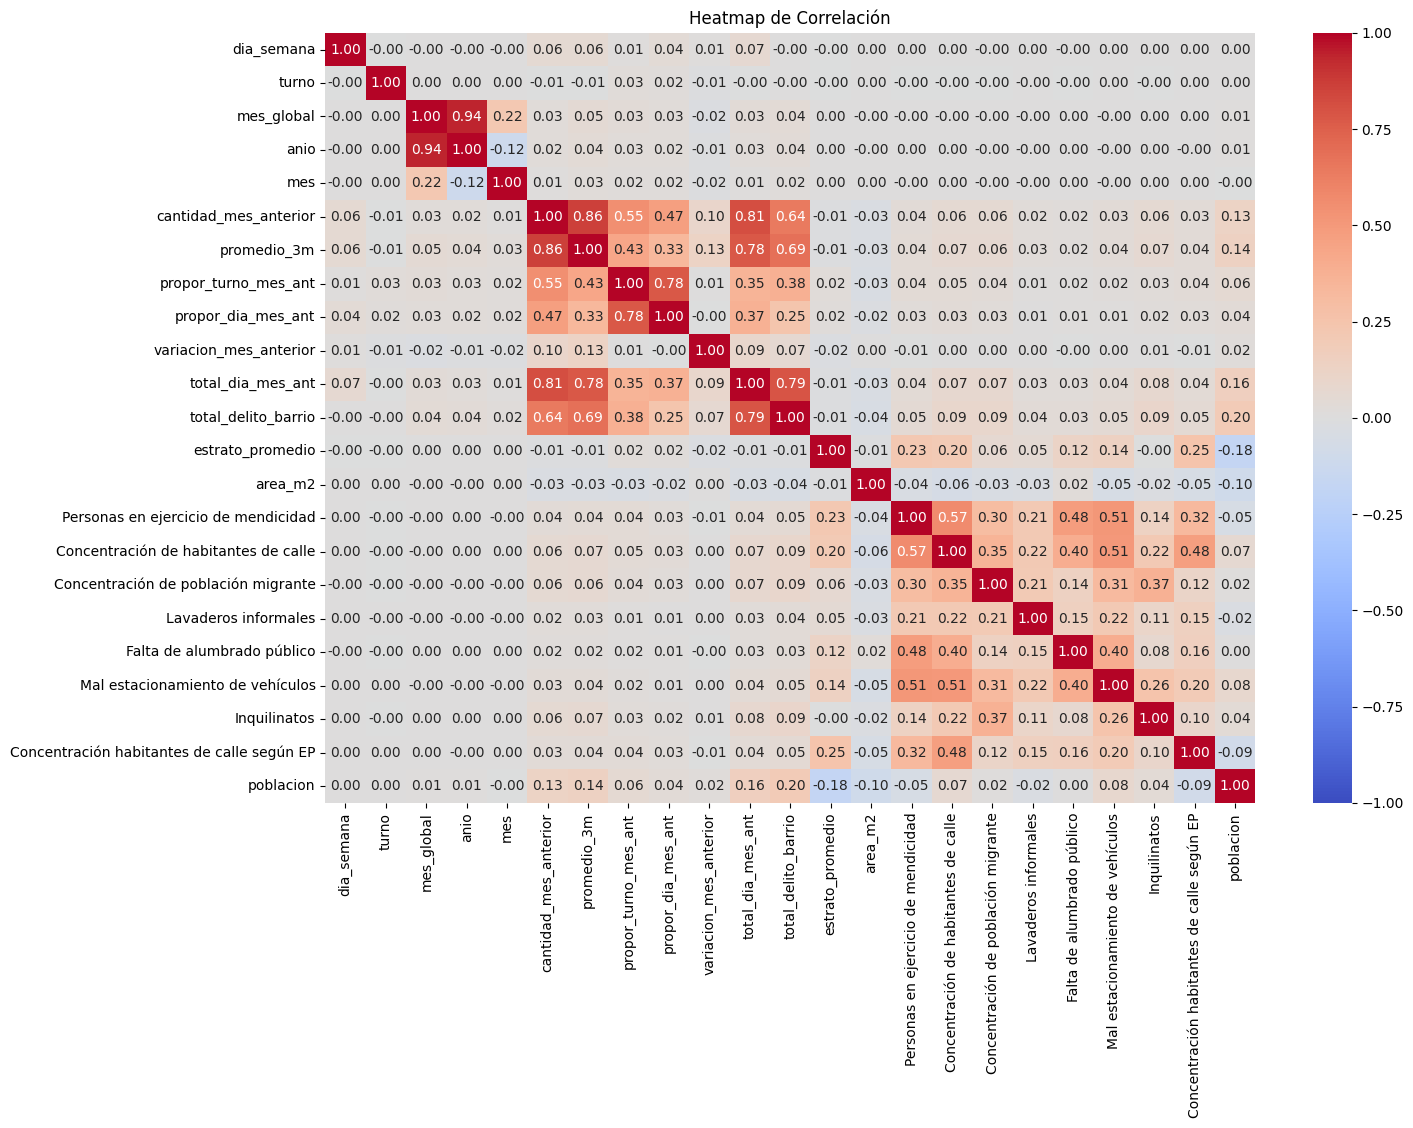

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapa de calor de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",vmin=-1, vmax=1, fmt=".2f")
plt.title("Heatmap de Correlación")
plt.show()

In [15]:
#librerias necesarias
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
from xgboost import XGBRegressor

In [16]:
#División entre test y prueba
target_zona = 'cantidad'

X_zona = df_scaled.drop(columns=[target_zona])
y_zona = df_scaled[target_zona]

# Dividir en train/test
X_train_zona, X_test_zona, y_train_zona, y_test_zona = train_test_split(
    X_zona, y_zona, test_size=0.2, random_state=42)

print("Datos divididos:")
print("X_train:", X_train_zona.shape, "X_test:", X_test_zona.shape)
print("y_train:", y_train_zona.shape, "y_test:", y_test_zona.shape)


Datos divididos:
X_train: (1723310, 338) X_test: (430828, 338)
y_train: (1723310,) y_test: (430828,)


---------------------- GridSearchCV +cv ------------------------------

In [ ]:
# Mejores hiperparámetros para Regresión lineal y arboles de desición
modelos_LAR = {
    "lr": LinearRegression(),
    "dt": DecisionTreeRegressor(random_state=42)
}

# Definimos los grids de hiperparámetros
param_grids = {
    "lr": {},  # Regresión Lineal: sin hiperparametros para ajustar en este ejemplo

    "dt": {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10]
    }
}

# Validación cruzada + GridSearch para cada modelo
cv = KFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
for nombre, modelo in modelos_LAR.items():
    print(f"\n Buscando mejor {nombre.upper()}...")
    grid = GridSearchCV(
        estimator=modelo,
        param_grid=param_grids[nombre],
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_zona, y_train_zona)
    best_models[nombre] = grid.best_estimator_
    print(f" Mejor {nombre.upper()}: {grid.best_params_}")

# Función para evaluar un modelo en conjunto test
def evaluate(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"\n Métricas {name} ")
    print(f"MAE   : {mae:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print(f"R²    : {r2:.4f}")

# Evaluar los modelos ajustados
for nombre, modelo in best_models.items():
    evaluate(nombre.upper(), modelo, X_test_zona, y_test_zona)


🔍 Buscando mejor LR...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
✅ Mejor LR: {}

🔍 Buscando mejor DT...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Mejor DT: {'max_depth': 10, 'min_samples_split': 10}

📊 Métricas LR 📊
MAE   : 0.2421
MSE   : 0.4592
RMSE  : 0.6776
MAPE  : 52.93%
R²    : 0.5461

📊 Métricas DT 📊
MAE   : 0.2171
MSE   : 0.4546
RMSE  : 0.6742
MAPE  : 43.76%
R²    : 0.5506


In [23]:
#mejores hiperparámetros para Random forest
modelos_LAR = {
    "rf": RandomForestRegressor(random_state=42)
}

# Definimos los grids de hiperparámetros
param_grids = {
    "rf": {
        "n_estimators": [50, 100],
        "max_depth": [5, 10],
        "min_samples_split": [2, 5]
    }
}

# Validación cruzada + GridSearch para cada modelo
cv = KFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
for nombre, modelo in modelos_LAR.items():
    print(f"\n Buscando mejor {nombre.upper()}...")
    grid = GridSearchCV(
        estimator=modelo,
        param_grid=param_grids[nombre],
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_zona, y_train_zona)
    best_models[nombre] = grid.best_estimator_
    print(f" Mejor {nombre.upper()}: {grid.best_params_}")

# Función para evaluar un modelo en conjunto test
def evaluate(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"\n Métricas {name} ")
    print(f"MAE   : {mae:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print(f"R²    : {r2:.4f}")

# Evaluar el modelo ajustado
for nombre, modelo in best_models.items():
    evaluate(nombre.upper(), modelo, X_test_zona, y_test_zona)


 Buscando mejor RF...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
 Mejor RF: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

 Métricas RF 
MAE   : 0.2134
MSE   : 0.4163
RMSE  : 0.6452
R²    : 0.5885


In [ ]:
#mejores hiperparámetros para XGboox
modelos = {
    "xgb": XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Definimos los grids de hiperparámetros
param_grids = {
    "xgb": {
        "max_depth": [3, 6],
        "learning_rate": [0.05, 0.1],
        "n_estimators": [100, 200],
        "subsample": [0.8, 1],
        "colsample_bytree": [0.8, 1],
        "gamma": [0, 0.1]
    }
}
# Validación cruzada + GridSearch para Xgboost
cv = KFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
for nombre, modelo in modelos.items():
    print(f"\n Buscando mejor {nombre.upper()}...")
    grid = GridSearchCV(
        estimator=modelo,
        param_grid=param_grids[nombre],
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_zona, y_train_zona)
    best_models[nombre] = grid.best_estimator_
    print(f" Mejor {nombre.upper()}: {grid.best_params_}")

# Función para evaluar Xgboost en conjunto test
def evaluate(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"\n Métricas {name} ")
    print(f"MAE   : {mae:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print(f"R²    : {r2:.4f}")

# Evaluar el modelo ajustado
for nombre, modelo in best_models.items():
    evaluate(nombre.upper(), modelo, X_test_zona, y_test_zona)



🔍 Buscando mejor XGB...
Fitting 5 folds for each of 64 candidates, totalling 320 fits


c:\Users\USUARIO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
12 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "c:\Users\USUARIO\AppData\Local\Programs

✅ Mejor XGB: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1}

📊 Métricas XGB 📊
MAE   : 0.3316
MSE   : 0.7234
RMSE  : 0.8506
MAPE  : 1241014.40%
R²    : 0.6072


----------------------------------CV---------------------------

In [18]:
#definición de los parámetros del modelo
modelo_lr = LinearRegression()
modelo_dt = DecisionTreeRegressor(max_depth=10, random_state=42)
modelo_rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Para XGBoost: usar el wrapper sklearn para facilitar CV
params_zona = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'gamma': 0,
    'colsample_bytree': 1,
    'min_child_weight': 1,
    'subsample': 1,
    'verbosity': 1
}
modelo_xgb = XGBRegressor(**params_zona, n_estimators=200, random_state=42)

# Validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_evaluate(name, model, X, y):
    # usamos MSE como métrica base
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    rmse_scores = np.sqrt(-scores)
    print(f"\n CV {name} ")
    print(f"RMSE promedio:   {rmse_scores.mean():.4f}")
    print(f"RMSE desviación: {rmse_scores.std():.4f}")

# Ejecutar CV
cv_evaluate("Regresión Lineal", modelo_lr, X_zona, y_zona)
cv_evaluate("Árbol de Decisión", modelo_dt, X_zona, y_zona)
cv_evaluate("Random Forest", modelo_rf, X_zona, y_zona)
cv_evaluate("XGBoost", modelo_xgb, X_zona, y_zona)


 CV Regresión Lineal 
RMSE promedio:   0.6802
RMSE desviación: 0.0041

 CV Árbol de Decisión 
RMSE promedio:   0.6805
RMSE desviación: 0.0143

 CV Random Forest 
RMSE promedio:   0.6788
RMSE desviación: 0.0053

 CV XGBoost 
RMSE promedio:   0.6258
RMSE desviación: 0.0053


In [19]:
#Entrenamiento y evaluación
# Entrenar cada modelo en el conjunto train
modelo_lr.fit(X_train_zona, y_train_zona)
modelo_dt.fit(X_train_zona, y_train_zona)
modelo_rf.fit(X_train_zona, y_train_zona)
modelo_xgb.fit(X_train_zona, y_train_zona)

print("\nModelos entrenados.")

# Evaluar en el test set
def evaluate(name, model, X_test, y_test, is_xgb=False):
    if is_xgb:
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    y_test_safe = np.where(y_test == 0, 1e-5, y_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test_safe)) * 100
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n Métricas {name} ")
    print(f"MAE   : {mae:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print(f"R²    : {r2:.4f}")

# Evaluar
evaluate("Regresión Lineal", modelo_lr, X_test_zona, y_test_zona)
evaluate("Árbol de Decisión", modelo_dt, X_test_zona, y_test_zona)
evaluate("Random Forest", modelo_rf, X_test_zona, y_test_zona)
evaluate("XGBoost", modelo_xgb, X_test_zona, y_test_zona, is_xgb=True)


Modelos entrenados.

 Métricas Regresión Lineal 
MAE   : 0.2421
MSE   : 0.4592
RMSE  : 0.6776
R²    : 0.5461

 Métricas Árbol de Decisión 
MAE   : 0.2172
MSE   : 0.4604
RMSE  : 0.6785
R²    : 0.5449

 Métricas Random Forest 
MAE   : 0.2266
MSE   : 0.4559
RMSE  : 0.6752
R²    : 0.5493

 Métricas XGBoost 
MAE   : 0.2106
MSE   : 0.3877
RMSE  : 0.6226
R²    : 0.6168


In [21]:
import itertools
#  PREDICCIÓN FUTURA → REGENERAR FEATURES

next_mes = df_features["mes_global"].max() + 1

df_base = df_llamadas_post_agrupado.copy()
df_base["codigo_barrio"] = df_base["codigo_barrio"].astype(str)

# Crea todas las combinaciones para el mes futuro
dias    = sorted(df_base["dia_semana"].unique())
turnos  = sorted(df_base["turno"].unique())
barrios = sorted(df_base["codigo_barrio"].unique())
grupos  = sorted(df_base["grupo_caso"].unique())


df_future = pd.DataFrame(
    list(itertools.product(dias, turnos, barrios, grupos)),
    columns=["dia_semana","turno","codigo_barrio","grupo_caso"]
)

df_future["mes_global"] = next_mes

# Obtener historico de los ultimos 6 meses
hist = df_base.copy()

cols_keep = ["dia_semana","turno","codigo_barrio","grupo_caso",
             "mes_global","cantidad"]

hist = hist[cols_keep]

# Unir histórico + futuro para regenerar lags
df_tmp = pd.concat([hist, df_future], ignore_index=True)


# Regenerar todas las variables (LAG + ROLLING)
def fn_features(group):
    group = group.sort_values("mes_global").copy()
    group["cantidad_mes_anterior"] = group["cantidad"].shift(1)

    # VARIACIÓN usando directamente shift(2) y shift(3)
    var_2 = group["cantidad"].shift(2)
    var_3 = group["cantidad"].shift(3)

    group["variacion_mes_anterior"] = (
        (var_2 - var_3) / var_3
    ).replace([np.inf, -np.inf, np.nan], 0)

    # ROLLING
    group["promedio_3m"] = group["cantidad_mes_anterior"].rolling(3, min_periods=3).mean()
    
    return group

df_tmp = df_tmp.groupby(
    ["dia_semana","turno","codigo_barrio","grupo_caso"],
    group_keys=False
).apply(fn_features)


# Proporciones y totales
df_tmp["propor_turno_mes_ant"] = (
    df_tmp["cantidad_mes_anterior"] /
    df_tmp.groupby(
        ["dia_semana","codigo_barrio","grupo_caso","mes_global"]
    )["cantidad_mes_anterior"].transform("sum")
).fillna(0)

df_tmp["propor_dia_mes_ant"] = (
    df_tmp["cantidad_mes_anterior"] /
    df_tmp.groupby(
        ["turno","codigo_barrio","grupo_caso","mes_global"]
    )["cantidad_mes_anterior"].transform("sum")
).fillna(0)

df_tmp["total_dia_mes_ant"] = df_tmp.groupby(
    ["dia_semana","codigo_barrio","grupo_caso","mes_global"]
)["cantidad_mes_anterior"].transform("sum")

df_tmp["total_delito_barrio"] = df_tmp.groupby(
    ["codigo_barrio","grupo_caso","mes_global"]
)["cantidad_mes_anterior"].transform("sum")

# 5. Filtrar solo el mes futuro
df_future_full = df_tmp[df_tmp["mes_global"] == next_mes].copy()

# 6. ONE-HOT ENCODE 
df_future_proc = pd.get_dummies(
    df_future_full,
    columns=["codigo_barrio","grupo_caso"],
    drop_first=False
)

# Columnas que usa el modelo
columnas_modelo = X_train_zona.columns.tolist()

# Alinear columnas del modelo
for col in columnas_modelo:
    if col not in df_future_proc.columns:
        df_future_proc[col] = 0

df_future_proc = df_future_proc[columnas_modelo]
df_future_proc = df_future_proc.apply(pd.to_numeric, errors="coerce").fillna(0)

# PREDICCIÓN
df_future_full["prediccion"] = modelo_xgb.predict(df_future_proc)


df_future_full["prediccion"] = (
    df_future_full["prediccion"].clip(lower=0).round().astype(int)
)

df_future_full = df_future_full.sort_values("prediccion", ascending=False)

# Exportar datos en excel
df_future_full.to_excel("predicciones_proximo_mes.xlsx", index=False)

print("Predicción del próximo mes generada correctamente.")

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_21136\1503267933.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(fn_features)


Predicción del próximo mes generada correctamente.


In [ ]:
#Se aplica la priorización, tomando para cada comuna y problemática el barrio con un mayor pronóstico para cada franja horaria

#Se hace la lectura del dataset necesario
df_future_full = pd.read_excel("predicciones_proximo_mes.xlsx", engine="openpyxl")

#Se ajusta la forma de algunos códigos barrio
df_future_full["codigo_barrio"] = df_future_full["codigo_barrio"].astype(str).apply(
    lambda x: x.zfill(4) if x.isdigit() else x
)

#Se agrega la columna codigo_comuna
df_future_full = df_future_full.merge(
    df_features[["codigo_barrio", "codigo_comuna"]].drop_duplicates(),
    on="codigo_barrio",
    how="left"
)

df_top1 = (
    df_future_full
    .sort_values(
        by=[
            "codigo_comuna", "grupo_caso", "dia_semana", "turno",
            "prediccion", "promedio_3m", "cantidad_mes_anterior"
        ],
        ascending=[True, True, True, True, False, False, False]
    )
    .groupby(
        ["codigo_comuna", "grupo_caso", "dia_semana", "turno"]
    )
    .head(1)
    .reset_index(drop=True)
)

#Se exportan los datos en excel
df_top1.to_excel("barrios_priorizados.xlsx", index=False)

print("Barrios priorizados para el próximo mes generados correctamente.")